['MET12(2).xlsx', 'MET004.xlsx', 'MET009(2).xlsx', 'MET005.xlsx', 'MET002.xlsx', 'MET17.xlsx', 'MET12(1).xlsx', 'MET16.xlsx', 'MET009(1).xlsx', 'MET003.xlsx', 'MET010(1).xlsx', 'MET15.xlsx', 'MET14.xlsx', 'MET001.xlsx', 'MET13.xlsx']
Process file /Users/wujianmin/Documents/personal/pet/PET参数提取/MET/MET12(2).xlsx
Process file /Users/wujianmin/Documents/personal/pet/PET参数提取/MET/MET004.xlsx
Process file /Users/wujianmin/Documents/personal/pet/PET参数提取/MET/MET009(2).xlsx
Process file /Users/wujianmin/Documents/personal/pet/PET参数提取/MET/MET005.xlsx
Process file /Users/wujianmin/Documents/personal/pet/PET参数提取/MET/MET002.xlsx
Process file /Users/wujianmin/Documents/personal/pet/PET参数提取/MET/MET17.xlsx
Error in line number when processing file /Users/wujianmin/Documents/personal/pet/PET参数提取/MET/MET17.xlsx, expect 104, read 124
Process file /Users/wujianmin/Documents/personal/pet/PET参数提取/MET/MET12(1).xlsx
Process file /Users/wujianmin/Documents/personal/pet/PET参数提取/MET/MET16.xlsx
Process file /User

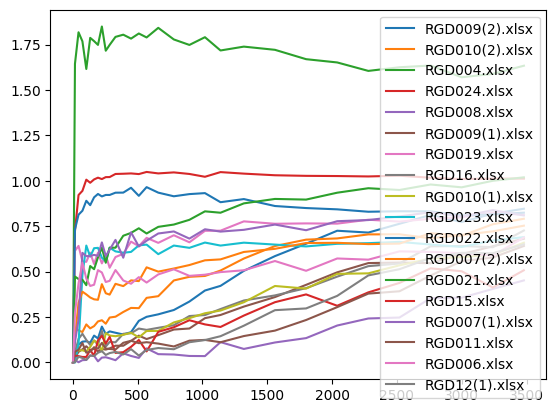

/var/folders/rs/vr_0_8kn2pn6ldh53stzbly80000gp/T/ipykernel_99294/297819962.py:98: RuntimeWarning: divide by zero encountered in divide
  met_ratio_1v2 = met_mat[0, :, 1:, 0:] / met_mat[1, :, 1:, :]
/var/folders/rs/vr_0_8kn2pn6ldh53stzbly80000gp/T/ipykernel_99294/297819962.py:98: RuntimeWarning: invalid value encountered in divide
  met_ratio_1v2 = met_mat[0, :, 1:, 0:] / met_mat[1, :, 1:, :]
/var/folders/rs/vr_0_8kn2pn6ldh53stzbly80000gp/T/ipykernel_99294/297819962.py:102: RuntimeWarning: divide by zero encountered in divide
  met_ratio_1v3 = met_mat[0, :, 1:, 0:] / met_mat[2, :, 1:, :]
/var/folders/rs/vr_0_8kn2pn6ldh53stzbly80000gp/T/ipykernel_99294/297819962.py:102: RuntimeWarning: invalid value encountered in divide
  met_ratio_1v3 = met_mat[0, :, 1:, 0:] / met_mat[2, :, 1:, :]
/Users/wujianmin/miniforge3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/var/folders/rs/vr_0_8kn2p

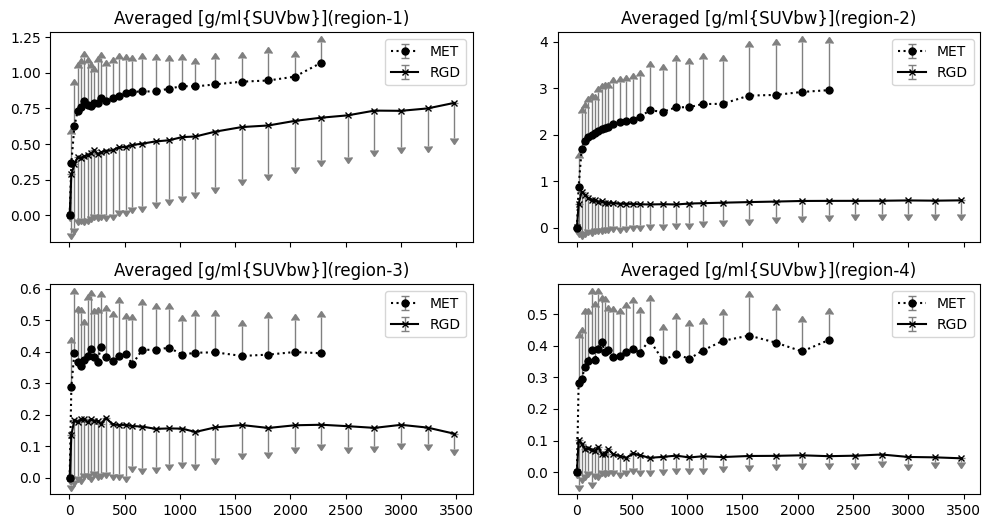

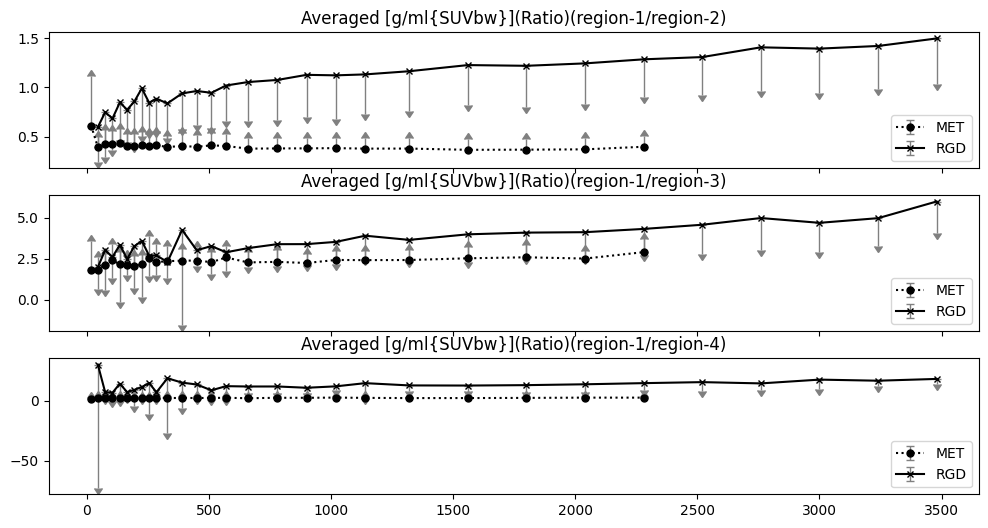

In [74]:
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

root_met = '/Users/wujianmin/Documents/personal/pet/PET参数提取/MET'
limit_row_met = 104

root_rgd = '/Users/wujianmin/Documents/personal/pet/PET参数提取2/RGD'
limit_row_rgd = 124

def read_data(root, row_num) :

    # VoiName(Region) [string]
    # Time [seconds]
    # Averaged [g/ml{SUVbw}]
    # Sd [g/ml{SUVbw}]
    # Volume [ccm]
    # Total(SUM) [g/ml{SUVbw}]
    # Total(AVR*VOL) [(g/ml{SUVbw})*(ccm)]
    # Min [g/ml{SUVbw}]
    # Max [g/ml{SUVbw}]

    files = os.listdir(root)
    files = [f if f.split('.')[-1] == 'xlsx' and not f.startswith('~') else None for f in files]
    
    print(files)

    nfiles = len(files)

    proj_cols = ['VoiName(Region) [string]', 'Time [seconds]', 
                'Averaged [g/ml{SUVbw}]', 'Sd [g/ml{SUVbw}]', 
                'Volume [ccm]', 'Total(SUM) [g/ml{SUVbw}]',
                'Total(AVR*VOL) [(g/ml{SUVbw})*(ccm)]', 
                'Min [g/ml{SUVbw}]', 'Max [g/ml{SUVbw}]']
    ncols = len(proj_cols)

    # tensor = torch.zeros((nfiles, :, :), dtype=torch.float)

    labels = [1, 2, 3, 4]
    mat_list = [[], [], [], []]


    err_count = 0
    files_selected = []
    for i, f in enumerate(files) :
        if f is None:
            continue
        fp = os.path.join(root, f)
        print(f"Process file {fp}")
        df = pd.read_excel(fp, sheet_name="Sheet1", header=7)
        
        try :
            # print(f"File {i}:{fp}: #nrows = {len(df)}, limit to {limit_row}")
            gdf = df.loc[:, proj_cols]
            if len(gdf) == row_num :
                # gdf = gdf.loc[1:limit_row, :]
                for k, label in enumerate(labels) :
                    df = gdf[gdf[proj_cols[0]] == label]
                    # select decrease curve
                    # df = df[df[proj_cols[2]].apply(lambda x : True if x[5:10] > x[-5:] else False)]
                    mat_list[k].append(df.loc[:, :].values)
                files_selected.append(f)
            else :
                err_count += 1
                print(f"Error in line number when processing file {fp}, expect {row_num}, read {len(df)}")
        except Exception as e:
            err_count += 1
            print(f"Error in process file {fp}: {e}")

    print(f'## Error file count: {err_count}/{len(files)}')

    # mat dimension:  [region, #rats, region-size ,features]
    mat = np.array(mat_list, dtype=np.float32)
    print(f"met_mat_shape: {mat.shape}")
    return mat, mat.mean(axis = 1), mat.std(axis=1), files_selected

# mat dimension:  [region, #rats, region-size ,features]
# mean dimension: [region, region-size ,features]
# std dimension:  [region, region-size ,features]
met_mat, met_mean, met_std, files = read_data(root_met, limit_row_met)
rgd_mat, rgd_mean, rgd_std, files = read_data(root_rgd, limit_row_rgd)

# debug data
for k in range(rgd_mat.shape[1]) :
    plt.plot(rgd_mat[0, k, :, 1], rgd_mat[0, k, :, 2])
plt.legend(files)
plt.show()

# calculate ratio
# print(met_mat[1, :, 1:, :])
ratio_labels = ['region-1/region-2', 'region-1/region-3', 'region-1/region-4']

met_ratio_1v2 = met_mat[0, :, 1:, 0:] / met_mat[1, :, 1:, :]
met_ratio_1v2_mean = met_ratio_1v2.mean(axis = 0) 
met_ratio_1v2_std = met_ratio_1v2.std(axis = 0) 

met_ratio_1v3 = met_mat[0, :, 1:, 0:] / met_mat[2, :, 1:, :]
met_ratio_1v3_mean = met_ratio_1v3.mean(axis = 0) 
met_ratio_1v3_std = met_ratio_1v3.std(axis = 0) 

met_ratio_1v4 = met_mat[0, :, 1:, 0:] / met_mat[3, :, 1:, :]
met_ratio_1v4_mean = met_ratio_1v4.mean(axis = 0) 
met_ratio_1v4_std = met_ratio_1v4.std(axis = 0) 

met_ratio = [met_ratio_1v2, met_ratio_1v3, met_ratio_1v4]
met_ratio_mean = [met_ratio_1v2_mean, met_ratio_1v3_mean, met_ratio_1v4_mean]
met_ratio_std = [met_ratio_1v2_std, met_ratio_1v3_std, met_ratio_1v4_std]

## 
rgd_ratio_1v2 = rgd_mat[0, :, 1:, 0:] / rgd_mat[1, :, 1:, :]
rgd_ratio_1v2_mean = rgd_ratio_1v2.mean(axis = 0) 
rgd_ratio_1v2_std = rgd_ratio_1v2.std(axis = 0) 

rgd_ratio_1v3 = rgd_mat[0, :, 1:, 0:] / rgd_mat[2, :, 1:, :]
rgd_ratio_1v3_mean = rgd_ratio_1v3.mean(axis = 0) 
rgd_ratio_1v3_std = rgd_ratio_1v3.std(axis = 0) 

rgd_ratio_1v4 = rgd_mat[0, :, 1:, 0:] / rgd_mat[3, :, 1:, :]
rgd_ratio_1v4_mean = rgd_ratio_1v4.mean(axis = 0) 
rgd_ratio_1v4_std = rgd_ratio_1v4.std(axis = 0) 

rgd_ratio = [rgd_ratio_1v2, rgd_ratio_1v3, rgd_ratio_1v4]
rgd_ratio_mean = [rgd_ratio_1v2_mean, rgd_ratio_1v3_mean, rgd_ratio_1v4_mean]
rgd_ratio_std = [rgd_ratio_1v2_std, rgd_ratio_1v3_std, rgd_ratio_1v4_std]

# show the plots
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, figsize=(12, 6))

for k, ax in enumerate(axs.flatten()) :
    ax.set_title('Averaged [g/ml{SUVbw}]' + f'(region-{k+1})')
    ax.errorbar(met_mean[k,:,1], met_mean[k, :, 2], yerr = met_std[k, :, 2], 
                fmt='o:',ecolor='gray', color = 'black', elinewidth=1,ms=5,mfc='black',mec='black',capsize=3, lolims = True)
    # ax0.errorbar(met_mean[0,:,1], met_mean[1, :, 2], yerr = met_std[1, :, 2])
    # ax0.errorbar(met_mean[0,:,1], met_mean[2, :, 2], yerr = met_std[2, :, 2])
    ax.errorbar(rgd_mean[k,:,1], rgd_mean[k, :, 2], yerr = rgd_std[k, :, 2],
                fmt='x-',ecolor='gray', color = 'black', elinewidth=1,ms=5,mfc='black',mec='black',capsize=3, uplims = True)
    ax.legend(['MET', 'RGD'])


fig, axs = plt.subplots(nrows = 3, ncols = 1, sharex=True, figsize=(12, 6))

for k, ax in enumerate(axs) :
    ax.set_title('Averaged [g/ml{SUVbw}](Ratio)' + f'({ratio_labels[k]})')
    ax.errorbar(met_mean[0, 1:, 1], met_ratio_mean[k][:, 2], yerr = met_ratio_std[k][:, 2], 
                fmt='o:',ecolor='gray', color = 'black', elinewidth=1,ms=5,mfc='black',mec='black',capsize=3, lolims = True)
    # ax1.errorbar(met_mean[0,:,1], met_mean[1, :, 5], yerr = met_std[1, :, 5])
    # ax1.errorbar(met_mean[0,:,1], met_mean[2, :, 5], yerr = met_std[2, :, 5])
    ax.errorbar(rgd_mean[0, 1:, 1], rgd_ratio_mean[k][:, 2], yerr = rgd_ratio_std[k][:, 2], 
                fmt='x-',ecolor='gray', color = 'black', elinewidth=1,ms=5,mfc='black',mec='black',capsize=3, uplims = True)
    ax.legend(['MET', 'RGD'])


(2, 26)
[[1.         0.79903765]
 [0.79903765 1.        ]]
(2, 2)


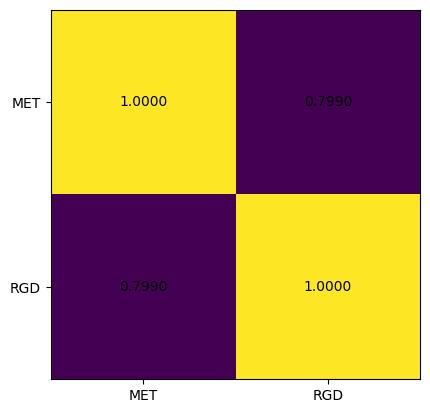

In [97]:
import numpy as np
import pandas as pd
# import seaborn as sns
## plot correlation
met_vec = met_mean[0, :, 2] 
rgd_vec = rgd_mean[0, :, 2][1:len(met_vec)+1]

data = np.array([met_vec, rgd_vec])
corr = np.corrcoef(data)
print(data.shape)

print(corr)
print(corr.shape)

labels = ['MET', 'RGD']
fig, ax = plt.subplots()
im = ax.imshow(corr)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

for i in range(len(labels)) :
    for j in range(len(labels)) :
        text = ax.text(j, i, f"{corr[i, j]:.4f}", ha='center', va='center', color='w')

plt.show()
